In [1]:
# In the notebooks 06x we ran a new time-evolution for each choice of the coefficients in Gamma.
# This was of course not necessary because the value of the THG does not affect the time-evolution.
# Since the fitting of the parameters becomes computationally intensive when large parameter
# spaces are investigated, we modified the evolution code to save all the input necessary to
# calculate the THG.  In this way, we can run the time-evolution only one and then actually fit
# the parameters.

# Here we fit the data without the pump beam (aka control beam).
# Ideally the results obtained here for Gamma can then be used to calculate
# the THG in the pump-probe cases and compare the results.

In [2]:
import time
from datetime import datetime
import math
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import simps
from scipy.optimize import minimize
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import json
from datetime import datetime
import multiprocessing as mp
import glob

In [3]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}

In [4]:
import models.graphene_thermodynamics_v2 as gt
from models.cooling_phonons_v3 import CoolingPhonons
from models.graphene_optics import GrapheneTHG

In [5]:
# Load interpolation data for the calculation of chemical potentials.
mm = gt.mu_func_use_2d_interpolation(load_from="mu_table.pkl")

# Evolutions for several Fermi energies.

In [6]:
# Run the evolution once.

def oneEvo(x):
    dyn = CoolingPhonons(**x["sysparams"])
    dyn.run(**x["runparams"])
    with open("%s/params-%02d-%02d.json" % (x["saveDir"], x["itK"], x["ieF"]), "w") as f:
        json.dump({"sysparams": x["sysparams"], "runparams": x["runparams"]}, f)
    with open("%s/thg_data-%02d-%02d.json" % (x["saveDir"], x["itK"], x["ieF"]), "w") as f:
        json.dump(dyn.p["thg_data"], f)
    return (x["itK"], x["ieF"], dyn.p["thg_data"])

In [7]:
# Dir to save results.
run_label = "example_for_appendix"
time_stamp = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
saveDir = "./data/07/%s_%s" % (time_stamp, run_label)
os.mkdir(saveDir)

# System's parameters common to all runs.
sysparams = {
    "tau_ph": 1200.0,
    "pu_fluenceSI": 0.0,
    "pu_dt": 50.0,
    "pu_eph": 1.200,
    "pr_delay": 50.0,
    "pr_fluenceSI": 130.0,  # ORIG: 130.0
    "pr_dt": 150.0,
    "pr_eph": 0.320,
    "nsub": 1.4,  # hBN encapsulated with SiO2 around
    "ntop": 1.4,
    "alpha_res": 1.0e-3,  # ORIG: 1.0e-3
    "gammaConst": 0.0,
    "gammaProp": 0.0,
    "gammaInv": 0.0,
    "dtdb": 200.0,  # ORIG: 200.0
    "ph_en_frac": 1.0,
    "dtdb_cutoff_dens": None,
    "pe_relax_rate": 0.0  # ORIG: 0.0
}

runparams = {
    "tmax": 250.0,  # integrate up to a bit later than the end of the probe pulse.
    "tnum": 51,  # need a finer time mesh, possibly aligned with the pulse
    "dt_approx": 5.0,
    "print_time": False    
}

# List of temperatures [K].
tempK_mesh = np.array([30.0, 300.0])
np.savetxt("%s/tempK_mesh.csv" % saveDir, tempK_mesh, delimiter=", ")

# List of Fermi energies [eV].
evo_eF_mesh = np.linspace(0.050, 0.250, 11)
np.savetxt("%s/eF_mesh.csv" % saveDir, evo_eF_mesh, delimiter=", ")

# Create a list of parameters, one for each run.
params_list = []
for itK,tempK in enumerate(tempK_mesh):
    for ieF,eF in enumerate(evo_eF_mesh):
        params_list.append({"itK": itK, "ieF": ieF, "saveDir": saveDir, 
                            "sysparams": {**sysparams, "tempK_eq": tempK, "eF": eF},
                            "runparams": runparams})

In [8]:
# Run the calculation.
with mp.Pool(24) as p:
    res_list = p.map(oneEvo, params_list)

In [9]:
# Collect the results.
thg_list = [[None for eF in evo_eF_mesh] for tK in tempK_mesh]
for res in res_list:
    thg_list[res[0]][res[1]] = res[2]

# Load experimental and evolution data.

In [10]:
# Load the experimental data.
power_in = 7.0e-3 # input power in W
exp_data = np.loadtxt("./data/from_omid/thg_vs_ef_no_pulse.csv", delimiter=",")
exp_eF_mesh = exp_data[:,0] * 1.0e-3  # convert to eV
exp_thg_300K = exp_data[:,1] * 1.0e-12 / power_in  # pW, convert to efficiency
exp_thg_30K = exp_data[:,2] * 1.0e-12 / power_in  # pW, convert to efficiency
exp_thg_list = [exp_thg_30K, exp_thg_300K]

In [11]:
class DataOneTemp():
    def __init__(self, label, tempK):
        self.label = label
        self.tempK = tempK

        
    def load_evolution(self, saveDir, itK):
        self.saveDir = saveDir
        self.evo_eF_mesh = np.loadtxt("%s/eF_mesh.csv" % self.saveDir, delimiter=", ")
        thg_list = []
        for ieF in range(len(self.evo_eF_mesh)):
            with open("%s/thg_data-%02d-%02d.json" % (self.saveDir, itK, ieF), "r") as f:
                thg_list.append(json.load(f))
        self.thg_list = thg_list

        
    def select_exp_data(self, exp_eF_mesh, exp_thg):
        self.exp_eF_mesh = exp_eF_mesh
        self.exp_thg = exp_thg
        # Select the experimental data within the calculated range of Fermi energies.
        # This will be used to calculate the cost function for the minimization.
        exp_sel = [i for i,e in enumerate(self.exp_eF_mesh) if e >= self.evo_eF_mesh[0] and e <= self.evo_eF_mesh[-1]]
        self.exp_sel_eF_mesh = self.exp_eF_mesh[exp_sel]
        self.exp_sel_thg = self.exp_thg[exp_sel]

        
    def model_fit_exp(self):

        def model_thg_func_from_coeffs(c):
            f = (lambda x: c[0] + c[1] * x + c[2] * x**2 + c[3] * x**3)
            return f

        def model_cost_function(lc):
            c = [10**l for l in lc]
            model_thg_func = model_thg_func_from_coeffs(c)
            model_thg = model_thg_func(self.exp_sel_eF_mesh)
            s = np.sqrt( np.mean((model_thg - self.exp_sel_thg)**2) )
            return s
        
        model_coeffs_guess = [1.0e-10, 1.0e-8, 1.0e-8, 1.0e-8]
        model_opt = minimize(
            model_cost_function, [np.log10(c) for c in model_coeffs_guess],
            method="Nelder-Mead")

        print("Success: ", model_opt.success)
        print("Message: ", model_opt.message)
        print("Cost function: ", model_opt.fun)

        model_opt_coeffs = [10**c for c in model_opt.x]
        self.model_opt_thg_func = model_thg_func_from_coeffs(model_opt_coeffs)
        # Use the std of this fit to estimate when a fit is "good".
        self.model_opt_cost = model_opt.fun
        
        
    def model_fit_plot(self):
        # Calculate the optimized profile of the THG on a finer mesh and compare to experiment.
        plot_eF_mesh = np.linspace(self.evo_eF_mesh[0], self.evo_eF_mesh[-1], 51)
        model_thg = np.array([self.model_opt_thg_func(eF) for eF in plot_eF_mesh])

        mpl.style.use(["classic", "latex"])
        fig = plt.figure(figsize=(3.5,3.0), frameon=True, dpi=150)
        plt.axes([0.2, 0.2, 0.7, 0.7])
        plt.plot(plot_eF_mesh, model_thg, "-", c="blue")
        plt.plot(self.exp_sel_eF_mesh, self.exp_sel_thg, "o", c="blue", ms=4.0, mew=0)
        plt.xlim([0.0, 0.3])
        plt.ylim([0.0, 1.0e-9])
        plt.xlabel(r"$\varepsilon_{\rm F}~[{\rm eV}]$")
        plt.ylabel(r"${\rm THG}$")
        plt.title(r"\scriptsize $T_{\rm L} = %.0f~{\rm K}$" % self.tempK)
        self.model_fit_fig = fig
    
        

Success:  True
Message:  Optimization terminated successfully.
Cost function:  1.9484547335186394e-11
Success:  True
Message:  Optimization terminated successfully.
Cost function:  1.6335125450735574e-11


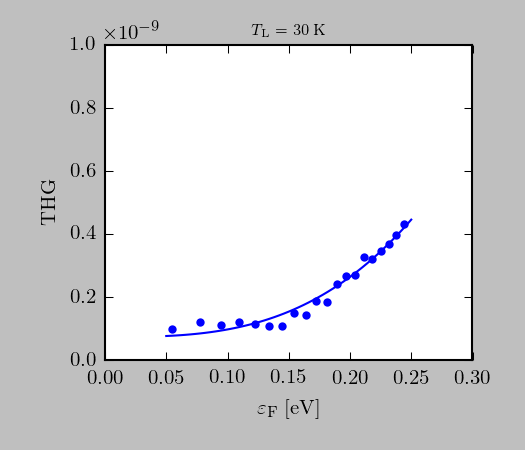

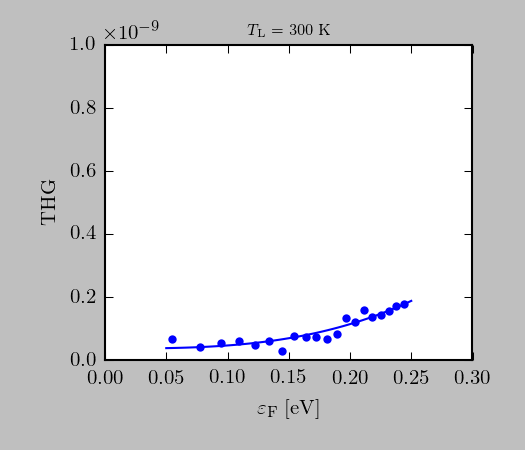

In [12]:
tempK_mesh = np.loadtxt("%s/tempK_mesh.csv" % saveDir, delimiter=", ")
data_temp = []
for itK, (tempK, exp_thg) in enumerate(zip(tempK_mesh, exp_thg_list)):
    data_temp.append(DataOneTemp("%.0fK" % tempK, tempK))
    data_temp[-1].load_evolution(saveDir, itK)
    data_temp[-1].select_exp_data(exp_eF_mesh, exp_thg)

for d in data_temp:
    d.model_fit_exp()
    d.model_fit_plot()


# Fit of the Gamma coefficients to the THG.

In [25]:
# Fit of the Gamma function. Choose a range where the fit should be performed.
# The interpolation range must be larger enough to include the values of the
# chemical potential that arise in the time-evolution, not just the values of
# the Fermi energies in the simulation or in the experiment.

In [26]:
fit_eF_min = 0.001
fit_eF_max = 0.500

In [27]:
# Expression for the Gamma function with fit coefficients.
# Some coefficients are the same at all temperature, other depend on temperature.
# The fit must be performed for all temperatures together, so that the constant
# coefficients can be uniquely determined.

fit_nr = 2
fit_coeffs_guess = [0.1, 0.001]  # initial guess of the fit coefficients
fit_coeffs_temp = [True, False]  # which coefficients depend on temperature

# Gamma = a * e_F + b / e_F + c * e_F * k_B * T_L
# The two fit coefficients correspond to the part that is proportional and
# inversely proportional to the Fermi energy, at given temperature:
# Gamma = (a + c k_B * T_L) * e_F + b / e_F
#       = gammaProp * e_F + gammaInv / e_F

def gamma_func_from_coeffs(c):
    f = lambda e: (c[0] * e + c[1] / e)
    return f

In [28]:
# Manage the coefficients that depend on temperature.
# Example: suppose c1,c3 constant, c2 depends on temperature 
# Decoded state: [[c1,c21,c3],[c1,c22,c3]] with c21,c22 two values at differente temperatures
# Encoded state: [c1,c3,c21,c22]

def encode_coeffs(cu):
    cw = []
    for ic,z in enumerate(fit_coeffs_temp):
        if not z:  # constant coefficient, copy many-to-one (i.e. just the first)
            cw.append(cu[0][ic])
    for ic,z in enumerate(fit_coeffs_temp):
        if z:  # temp-dep coefficient, copy one-to-one
            for cr in cu:
                cw.append(cr[ic])
    return cw
    
    
def decode_coeffs(cw):
    nct = fit_coeffs_temp.count(True)  # number of temp-dep coefficients
    ncc = fit_coeffs_temp.count(False)  # number of constant coefficients
    nc = nct + nct  # total number of coefficients
    nt = int( (len(cw) - ncc) / nct )  # number of temperatures, i.e. number of set of coefficients
    cu = [[None for ic in range(nc)] for it in range(nt)]
    j = 0  # index in the encoded list
    for ic,z in enumerate(fit_coeffs_temp):
        if not z:  # constant coefficient, copy one-to-manu
            for it in range(nt):
                cu[it][ic] = cw[j]
            j = j + 1
    for ic,z in enumerate(fit_coeffs_temp):
        if z:  # temp-dep coefficient, copy one-to-one
            for it in range(nt):
                cu[it][ic] = cw[j]
                j = j + 1
    return cu


In [29]:
# Test of the encoding/decoding of the fit parameters.
coeffs_dec = [["a","b"],["c","b"],["d","b"]]
coeffs_enc = encode_coeffs(coeffs_dec)
# print(coeffs_enc)
# print(decode_coeffs(coeffs_enc))

In [30]:
# Deal with an overall proportionality coefficient of the fit.
# We do not want this coefficient to vary too much from unity, still
# a little leeway could help.
# This would take care of an overall under- or over-estimate of the
# experimental value of the THG.
# To force the fit between two limits, parametrize its log as an arctan.
aprop_min = 0.01
aprop_max = 10.0
def encode_aprop(aprop):
    x0 = np.log10(aprop_min)
    x1 = np.log10(aprop_max)
    x = np.log10(aprop)
    y = np.pi * (x - 0.5 * (x0 + x1)) / (x1 - x0)
    aprop_enc = np.tan(y)
    return aprop_enc

def decode_aprop(aprop_enc):
    x0 = np.log10(aprop_min)
    x1 = np.log10(aprop_max)
    y = np.arctan(aprop_enc)
    x = y / np.pi * (x1 - x0) + 0.5 * (x0 + x1)
    aprop = 10.0**x
    return aprop

In [31]:
# Calculation of the cost function for the minimization.
# Several functions are needed.

# Calculate the THG from the data of one evolution.
# Needs a specific Gamma function.

def oneTHG(x):
    thg = GrapheneTHG(**x["init"])
    thg.calculate_eta(**x["calc"])
    eta = thg.p["eta"]
    return (x["i"], eta)


def calculate_thg(thg_data, gamma_func):
    # The parameters for the THG in time, during the probe pulse. 
    params_list = []
    for i,args in enumerate(thg_data["args"]):
        # Calculate the correct value of Gamma given the chemical potentials.
        mu_avg = 0.5 * (np.abs(args["muC"]) + np.abs(args["muV"]))
        gamma = gamma_func(np.array([mu_avg]))[0]  # works with arrays
        # Prepare the parameters for one calculation of the THG.
        params = {}
        params["i"] = i
        params["init"] = {**thg_data["init"], "gammaConst": gamma, "gammaProp": 0.0, "gammaInv": 0.0}
        params["calc"] = args.copy()
        params_list.append(params)
    
    # Run the calculation.
    with mp.Pool(24) as p:
        res_list = p.map(oneTHG, params_list)

    # The THG in time.
    thg_t = np.zeros(len(thg_data["time"]))
    for res in res_list:
        thg_t[res[0]] = res[1]
    
    # Time-average of the THG.
    tt = np.array(thg_data["time"])
    thg_avg = simps(thg_t, tt) / (tt[-1] - tt[0])
    return thg_avg


# Cost function for the minimization.
# Calculates the THG on the evolution mesh,
# interpolates it on the experimental mesh,
# and calculates the standard deviation.

def thg_func_from_coeffs(data, coeffs):
    # The Gamma function given these coefficients.
    gamma_func = gamma_func_from_coeffs(coeffs)
    # Calculate the THG on the evolution mesh.
    evo_thg = np.array([calculate_thg(thg_data, gamma_func) for thg_data in data.thg_list])
    # Interpolate calculated values.
    thg_func = interp1d(data.evo_eF_mesh, evo_thg, kind="cubic")
    return thg_func

icf = 0  # counter for the evaluations of the cost function
def cost_function(fitcoeffs):
    aprop = decode_aprop(fitcoeffs[0])
    logcoeffs_enc = fitcoeffs[1:]
    logcoeffs_temp = decode_coeffs(logcoeffs_enc)
    s_temp = []
    for data,logcoeffs in zip(data_temp,logcoeffs_temp):
        # Interpolate the THG on the experimental mesh.
        thg_func = thg_func_from_coeffs(data, [10**c for c in logcoeffs])
        itp_thg = thg_func(data.exp_sel_eF_mesh)
        # Calculate the standard deviation.
        s = np.sqrt( np.mean((aprop * itp_thg - data.exp_sel_thg)**2) )
        # Divide by the standard deviation of a "good" fit.
        s_temp.append(s / data.model_opt_cost)
    s = np.array(s_temp).mean()
    # Print calls.
    global icf
    icf = icf + 1
    if (icf % 10) == 1:
        msg = "%.4e | " % aprop
        for l in logcoeffs_enc:
            msg = msg + ("%.4e " % (10**l))
        msg = msg + ("| %.4e" % s)
        print(msg)
    return s

In [32]:
# Minimize the values of the cost function.
# The minimization works with the logarithms of the coefficients.
t0 = time.time()
logcoeffs_guess = [[np.log10(c) for c in fit_coeffs_guess] for it in range(len(data_temp))]
aprop_guess = 1.0  
fitcoeffs = [encode_aprop(aprop_guess)] + encode_coeffs(logcoeffs_guess)
opt = minimize(cost_function, fitcoeffs,
               method="Nelder-Mead",
               options={"disp": True, "return_all": False})
t1 = time.time()

print("Success: ", opt.success)
print("Message: ", opt.message)
print("Elapsed time: ", t1-t0)

# Optimized coefficients.
opt_aprop = decode_aprop(opt.x[0])
opt_coeffs_dec = decode_coeffs([10**c for c in opt.x[1:]])

# Save the results of the minimization to the data structures.
print(opt_aprop)
for opt_coeffs in opt_coeffs_dec:
    print(opt_coeffs)
for data,opt_coeffs in zip(data_temp,opt_coeffs_dec):
    data.opt_aprop = opt_aprop
    data.opt_coeffs = opt_coeffs

1.0000e+00 | 1.0000e-03 1.0000e-01 1.0000e-01 | 3.7356e+02
8.7892e-01 | 1.1949e-03 9.1234e-02 8.8645e-02 | 3.2679e+02
3.1947e-01 | 2.3337e-02 3.2753e-02 3.7834e-02 | 4.8032e+00
3.4527e-01 | 1.8361e-02 3.9904e-02 4.2512e-02 | 8.4559e+00
3.9439e-01 | 1.9137e-02 4.2133e-02 4.1442e-02 | 8.8222e+00
3.1132e-01 | 2.4718e-02 3.4457e-02 3.8322e-02 | 4.9619e+00
3.2806e-01 | 2.3561e-02 3.5900e-02 3.9456e-02 | 4.8151e+00
3.0362e-01 | 2.3109e-02 2.9296e-02 3.5930e-02 | 4.7848e+00
2.0927e-01 | 2.0940e-02 1.2294e-02 2.3517e-02 | 4.7131e+00
7.1173e-02 | 1.3285e-02 5.7614e-04 5.5273e-03 | 4.5683e+00
1.7092e-02 | 1.3869e-03 5.2086e-11 2.5161e-06 | 4.0367e+00
1.7446e-02 | 1.5313e-03 1.2104e-10 3.7327e-06 | 4.0422e+00
1.5049e-02 | 5.1734e-04 7.1785e-14 1.1244e-07 | 4.0134e+00
1.6253e-02 | 8.4024e-04 5.6178e-12 9.0871e-07 | 4.0042e+00
1.6005e-02 | 5.9140e-04 2.7559e-12 6.6154e-07 | 3.9863e+00
1.6099e-02 | 2.6136e-04 5.4566e-12 1.0132e-06 | 3.9601e+00
1.6408e-02 | 1.7996e-04 1.4524e-11 1.7291e-06 | 3.9577e+

In [33]:
# Save parameters.
with open("%s/fit_params.txt" % saveDir, "w") as f:
    f.write("%15.8f\n" % data_temp[0].opt_aprop)
    for data in data_temp:
        s = ", ".join(["%15.8f" % x for x in data.opt_coeffs])
        f.write(s + "\n")

In [34]:
# Analyze the temperature-dependence coefficients, in terms of constants,
# that is, solve
# a + b 30.0/11600.0 = gammaProp(30K)
# a + b 300.0/11600.0 = gammaProp(300K)
# with the values of gammaProp(T) obtained by the fits.
# This is NOT generic and depends on the two dataset that we actually have.
# The value of b is just gammaInv, which does not depend on time.
# For each dataset, the two coefficients are [gammaProp, gammaInv].

kB = 1.0/11600.0
t1 = data_temp[0].tempK
k1 = data_temp[0].opt_coeffs[0]  # gammaProp(30.0)
t2 = data_temp[1].tempK
k2 = data_temp[1].opt_coeffs[0]  # gammaProp(30.0)
a = (k1 * t2 - k2 * t1) / (t2-t1)
c = (k2 - k1) / (t2-t1)
b = data_temp[0].opt_coeffs[1]  # gammaInv
res = "a = %.6f\nb = %.6f\nc = %.6f\n" % (a, b, c)
print(res)
with open("%s/fit_params_named.txt" % saveDir, "w") as f:
    f.write(res)

a = -0.000000
b = 0.000000
c = 0.000000



# Plot results.

In [35]:
# Calculate the optimized profile of the THG on a finer mesh.
for data in data_temp:
    data.opt_eF_mesh = np.linspace(data.evo_eF_mesh[0], data.evo_eF_mesh[-1], 51)
    opt_thg_func = thg_func_from_coeffs(data, data.opt_coeffs)
    data.opt_thg = data.opt_aprop * np.array([opt_thg_func(eF) for eF in data.opt_eF_mesh])

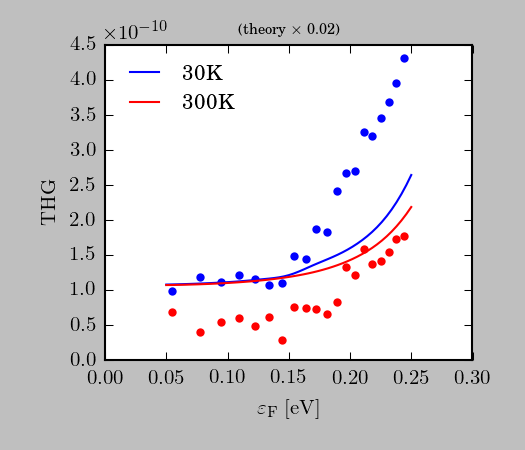

In [36]:
# Compare the THG to the experiments.
mpl.style.use(["classic", "latex"])
plt.figure(figsize=(3.5,3.0), frameon=True, dpi=150)
plt.axes([0.2, 0.2, 0.7, 0.7])
colors = ["blue", "red"]
for data,c in zip(data_temp,colors):
    plt.plot(data.opt_eF_mesh, data.opt_thg, "-", c=c, label=data.label)
    plt.plot(data.exp_sel_eF_mesh, data.exp_sel_thg, "o", c=c, ms=4.0, mew=0)
plt.xlim([0.0, 0.3])
#plt.ylim([0.0, 5.0e-10])
plt.xlabel(r"$\varepsilon_{\rm F}~[{\rm eV}]$")
plt.ylabel(r"${\rm THG}$")
plt.legend(frameon=False, loc="upper left")
plt.title(r"\scriptsize (theory $\times$ %.2f)" % data_temp[0].opt_aprop)
plt.savefig("%s/thg_vs_ef.png" % saveDir, dpi=300);

# Save the plot data.
np.savetxt("%s/thg_vs_ef.csv" % saveDir,
           np.c_[data_temp[0].opt_eF_mesh,data_temp[0].opt_thg,data_temp[1].opt_thg], delimiter=", ")